## Placing a trade order with Quantopian

https://pythonprogramming.net/placing-an-order-quantopian-python-programming-for-finance/

Welcome to part 14 of the Python for Finance tutorial series, using Quantopian. In this tutorial, we're going to be covering how to actually place an order for stock (buy/sell/short).

Up to this point, we have the following code:

In [1]:
def initialize(context):
    context.aapl = sid(24)
    
def handle_data(context,data):
    
    # prices for aapl for the last 50 days, in 1 day intervals
    hist = data.history(context.aapl,'price', 50, '1d')
    
    # mean of the entire 50 day history
    sma_50 = hist.mean()
    
    # mean of just the last 50 days
    sma_20 = hist[-20:].mean()

What we've done so far is define what context.aapl is, then we grabbed historical prices for AAPL, and, using those prices, generated some code to calculate, at every interval, what the 50 and 20 simple moving averages are. Our plan is to create a simple moving average crossover strategy, and we're almost ready. The logic should be simple: If the 20 SMA is greater than the 50 SMA, then the price is rising, and we want in on that action! If the 20 SMA is less than the 50 SMA, then price is falling, and we want to short (bet against) the company. Let's build an ordering system to reflect this:

In [2]:
    # if sma_20 > sma_50:
    #     order_target_percent(context.aapl, 1.0)
    # elif sma_20 < sma_50:
    #     order_target_percent(context.aapl, -1.0)

The `order_target_percent` function is used to allow us to invest a certain percentage of our portfolio value into a company. In this case, the only company we're even consider is Apple (AAPL), so we're using 1.0 (100%). There are many [methods for ordering](https://www.quantopian.com/help), this is just one of them. We can do market orders, order specific dollar amounts, order percents, order a target value, and of course cancel pending orders. We're expecting to simply buy/sell 100% of our shares at each step in this case. If we run this, we get:

![](https://pythonprogramming.net/static/images/finance/python-quantopian-investing-pitfalls.png)

Holy smokes! Jackpot! We're gonna be rich!

...just not with this strategy.

When you first write an algorithm, especially when starting out, something like this is fairly likely to occur. Maybe it's in your favor, or maybe you lost 1000% of your starting money, and you're wondering what happened. In this case, it is super easy to spot. First off, our returns are incredibly unlikely, and, given just the basic readout from Quantopian, we can see that immediately we're doing transactions to the tune of multiple 10's of millions of dollars, and even hundreds of millions of dollars, when our starting capital was meant to be $1 million.

So what happened here? Quantopian is built to allow you to do whatever you want, and there are no restrictions on "loans." When you take on loans to invest with in the world of finance, it's usually referred to as leverage. This account is severely over leveraged, and it's exactly what we asked for.

Learning how to diagnose this, and hopefully avoid this in the future is extremely important!

The first step is to pretty much always record leverage. Let's do that now:

In [3]:
def initialize(context):
    context.aapl = sid(24)
    
def handle_data(context,data):
    hist = data.history(context.aapl,'price', 50, '1d')
    
    sma_50 = hist.mean()
    sma_20 = hist[-20:].mean()
    
    if sma_20 > sma_50:
        order_target_percent(context.aapl, 1.0)
    elif sma_20 < sma_50:
        order_target_percent(context.aapl, -1.0)
        
    record(leverage = context.account.leverage)

With record, we can track up to five values. In this case, we're just choosing one. We're looking at our account's leverage, which is automatically tracked for us in context.account.leverage. You can see other options there, just by doing context. or context.account. and so on to see with the auto-complete what your choices are. You can use record to track other values as well, this is just an example.

Just running this for a moment, we can see leverage is indeed getting way out of hand:

![](https://pythonprogramming.net/static/images/finance/leverage-python-quantopian-tutorial.png)

Okay, so we're over leveraged. What actually happened? Well, for one, this handle_data function is being run every single minute. Thus, every minute, we can be plausibly ordering, and, in this case, that's ordering 100% of our portfolio's value. We think we're safe, because we're ordering a target percentage. If the target percentage is 100%, how are we winding up with so much more? The problem is, it can take time for orders to actually fill. Thus, as one order is waiting to be filled, others are being made at the same time!

The first thing we might want to do to avoid this, is to use the `get_open_orders()` method, as follows:

In [4]:
    # open_orders = get_open_orders()
    
    # if sma_20 > sma_50:
    #     if context.aapl not in open_orders:
    #         order_target_percent(context.aapl, 1.0)
    # elif sma_20 < sma_50:
    #     if context.aapl not in open_orders:
    #         order_target_percent(context.aapl, -1.0)

Now, before every order, we're checking to see if we have any pending orders already for this company. Let's run that.

One note that I'd like to make is, there's really no way for you to know that `get_open_orders()` exists, unless you read the docs. I will show you quite a few methods and functions, but I certainly wont cover them all. Definitely make sure you scroll through the Quantopian API Docs to see what's available to you. You don't need to read it all, just glaze through it and read about the functions that catch your eyes. The functions/methods are in red, so it's really easy to catch them as you scroll through.

The results of that run:

![](https://pythonprogramming.net/static/images/finance/leverage-under-control.png)

The deviations you see are like 1 +/- 0.0001. We effectively maintained a leverage of 1 this entire time, as we wanted, but...hmm...that return is not so hot!

One thing we can see by clicking on "Transaction Details" on the left nav is that we're making many trades a day. We can see some of our transaction bars are also quite large, sometimes almost $10 million. What's happening here? We also thought we were supposed to be just trading once a day at most.

Instead, the `handle_data` function is running every minute, so, again, we actually can still be placing trades every minute. If we're looking to do things that aren't assessing the market every minute, we might actually be looking instead to schedule functions. Luckily we can do that, and that's the topic of the next tutorial!

### [zipline-reloaded](https://github.com/stefan-jansen/zipline-reloaded):

In [5]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext zipline

Returns: -24.43% | Benchmark: 74.54% | Alpha: -0.06 | Beta: 0.01
Sharpe: -0.26 | Sortino: -0.36 | Volatility: 0.23
Max Drawdown: -40.15%


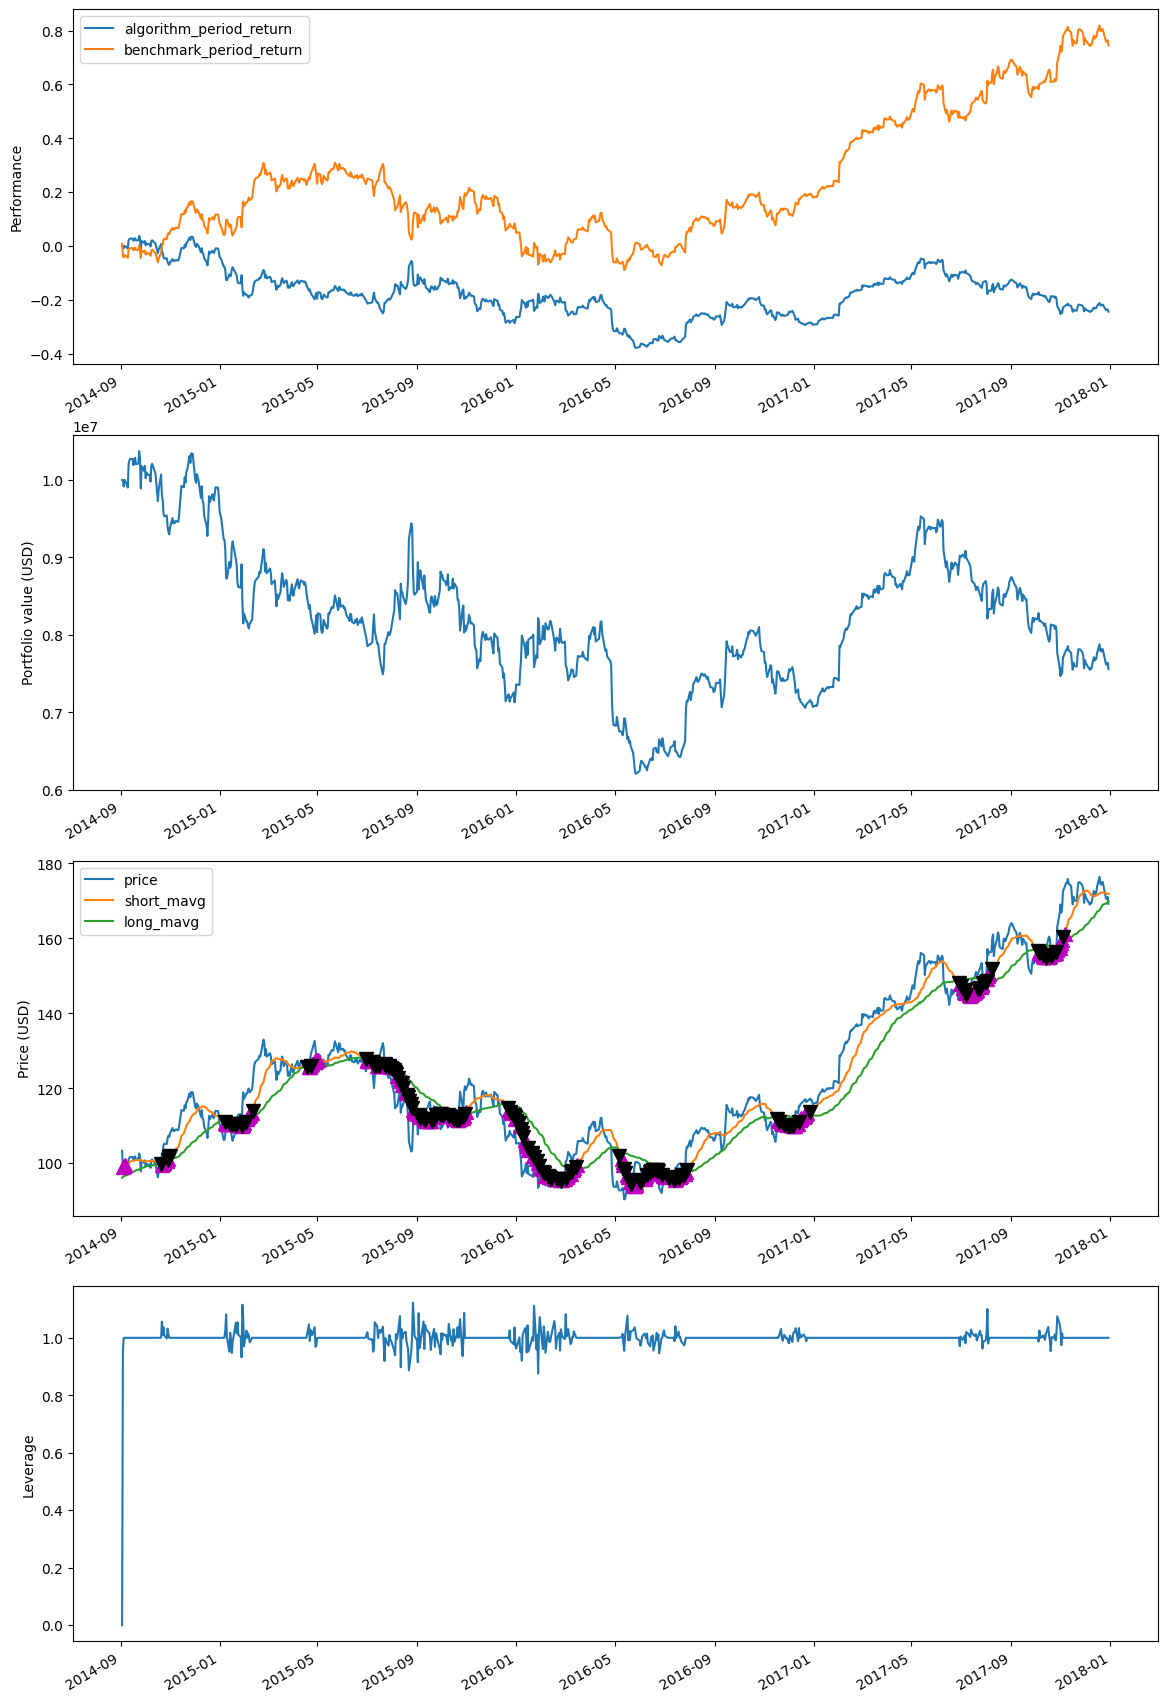

,period_open,period_close,positions,starting_exposure,gross_leverage,ending_exposure,starting_value,net_leverage,ending_value,starting_cash,...,algorithm_period_return,max_leverage,excess_return,treasury_period_return,trading_days,period_label,sharpe,algo_volatility,benchmark_period_return,benchmark_volatility
2014-09-02 20:00:00+00:00,2014-09-02 13:31:00+00:00,2014-09-02 20:00:00+00:00,[],0.00,0.000000,0.00,0.00,0.000000,0.00,1.000000e+07,...,0.000000,0.000000,0.0,0.0,1,2014-09,NaN,NaN,0.007808,NaN
2014-09-03 20:00:00+00:00,2014-09-03 13:31:00+00:00,2014-09-03 20:00:00+00:00,"[{'sid': Equity(8 [AAPL]), 'amount': 96805, 'c...",0.00,0.958257,9577886.70,0.00,0.958257,9577886.70,1.000000e+07,...,-0.000489,0.958257,0.0,0.0,2,2014-09,-11.224972,0.005484,-0.034727,0.561388
2014-09-04 20:00:00+00:00,2014-09-04 13:31:00+00:00,2014-09-04 20:00:00+00:00,"[{'sid': Equity(8 [AAPL]), 'amount': 101021, '...",9577886.70,0.999663,9912180.52,9577886.70,0.999663,9912180.52,4.172276e+05,...,-0.008448,0.999663,0.0,0.0,3,2014-09,-10.020303,0.070849,-0.042730,0.405268
2014-09-05 20:00:00+00:00,2014-09-05 13:31:00+00:00,2014-09-05 20:00:00+00:00,"[{'sid': Equity(8 [AAPL]), 'amount': 101055, '...",9912180.52,1.000002,10001413.35,9912180.52,1.000002,10001413.35,3.342579e+03,...,0.000139,1.000002,0.0,0.0,4,2014-09,0.121543,0.107911,-0.034438,0.377505
2014-09-08 20:00:00+00:00,2014-09-08 13:31:00+00:00,2014-09-08 20:00:00+00:00,"[{'sid': Equity(8 [AAPL]), 'amount': 101055, '...",10001413.35,1.000002,9939769.80,10001413.35,1.000002,9939769.80,-2.411780e+01,...,-0.006025,1.000002,0.0,0.0,5,2014-09,-2.904254,0.103348,-0.040389,0.327352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 21:00:00+00:00,2017-12-22 14:31:00+00:00,2017-12-22 21:00:00+00:00,"[{'sid': Equity(8 [AAPL]), 'amount': 44657, 'c...",7815421.57,0.999986,7815421.57,7815421.57,0.999986,7815421.57,1.118070e+02,...,-0.218447,1.122507,0.0,0.0,836,2017-12,-0.213031,0.227442,0.805027,0.228260
2017-12-26 21:00:00+00:00,2017-12-26 14:31:00+00:00,2017-12-26 21:00:00+00:00,"[{'sid': Equity(8 [AAPL]), 'amount': 44657, 'c...",7815421.57,0.999985,7617144.49,7815421.57,0.999985,7617144.49,1.118070e+02,...,-0.238274,1.122507,0.0,0.0,837,2017-12,-0.246053,0.227725,0.759233,0.228575
2017-12-27 21:00:00+00:00,2017-12-27 14:31:00+00:00,2017-12-27 21:00:00+00:00,"[{'sid': Equity(8 [AAPL]), 'amount': 44657, 'c...",7617144.49,0.999985,7618484.20,7617144.49,0.999985,7618484.20,1.118070e+02,...,-0.238140,1.122507,0.0,0.0,838,2017-12,-0.245674,0.227589,0.759543,0.228439
2017-12-28 21:00:00+00:00,2017-12-28 14:31:00+00:00,2017-12-28 21:00:00+00:00,"[{'sid': Equity(8 [AAPL]), 'amount': 44657, 'c...",7618484.20,0.999985,7639919.56,7618484.20,0.999985,7639919.56,1.118070e+02,...,-0.235997,1.122507,0.0,0.0,839,2017-12,-0.241806,0.227459,0.764494,0.228306


In [6]:
%%zipline --start=2014-9-1 --end=2018-1-1 --benchmark-symbol AAPL

import numpy as np
import matplotlib.pyplot as plt
from zipline.api import order_target_percent, record, symbol, get_open_orders


def initialize(context):
    context.aapl = symbol("AAPL")


def handle_data(context, data):

    # Compute averages
    # history() has to be called with the same params
    # from above and returns a pandas dataframe.
    sma_short = data.history(context.aapl, "price", 20, "1d").mean()
    sma_long = data.history(context.aapl, "price", 50, "1d").mean()
    
    open_orders = get_open_orders()

    # Trading logic
    if sma_short > sma_long:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, 1.0)
    elif sma_short < sma_long:
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, -1.0)

    # Save values for later inspection
    record(
        price=data.current(context.aapl, "price"),
        short_mavg=sma_short,
        long_mavg=sma_long,
        leverage = context.account.leverage,
    )


# Note: this function can be removed if running
# this algorithm on quantopian.com
def analyze(context=None, results=None):
    
    # Algorithm Metrics
    returns = results['algorithm_period_return'].iloc[-1]
    benchmark = results['benchmark_period_return'].iloc[-1]
    alpha = round(results['alpha'].iloc[-1], 2)
    beta = round(results['beta'].iloc[-1], 2)
    sharpe = results['sharpe'].iloc[-1]
    sortino = results['sortino'].iloc[-1]
    volatility = round(results['algo_volatility'].iloc[-1], 2)
    max_drawdown = results['max_drawdown'].iloc[-1]
    print(f'Returns: {returns * 100:.2f}% | Benchmark: {benchmark * 100:.2f}% | Alpha: {alpha} | Beta: {beta}')
    print(f'Sharpe: {sharpe:.2f} | Sortino: {sortino:.2f} | Volatility: {volatility}')
    print(f'Max Drawdown: {max_drawdown * 100:.2f}%')

    # Plot chart
    fig = plt.figure(figsize=[14, 24])
    
    ax1 = fig.add_subplot(411)
    results[['algorithm_period_return', 'benchmark_period_return']].plot(ax=ax1)
    ax1.set_ylabel("Performance")
    
    ax2 = fig.add_subplot(412)
    results.portfolio_value.plot(ax=ax2)
    ax2.set_ylabel("Portfolio value (USD)")

    ax3 = fig.add_subplot(413)
    ax3.set_ylabel("Price (USD)")

    # If data has been record()ed, then plot it.
    if "price" in results and "short_mavg" in results and "long_mavg" in results:
        results["price"].plot(ax=ax3)
        results[["short_mavg", "long_mavg"]].plot(ax=ax3)

        trans = results[[t != [] for t in results.transactions]]
        buys = trans[[t[0]["amount"] > 0 for t in trans.transactions]]
        sells = trans[[t[0]["amount"] < 0 for t in trans.transactions]]
        ax3.plot(
            buys.index,
            results.short_mavg.loc[buys.index],
            "^",
            markersize=10,
            color="m",
        )
        ax3.plot(
            sells.index,
            results.short_mavg.loc[sells.index],
            "v",
            markersize=10,
            color="k",
        )
        plt.legend(loc=0)
    else:
        msg = "price, short_mavg & long_mavg data not captured using record()."
        ax3.annotate(msg, xy=(0.1, 0.5))
    
    ax4 = fig.add_subplot(414)
    results.leverage.plot(ax=ax4)
    ax4.set_ylabel("Leverage")

    plt.show()